In [1]:
from IPython.display import display, HTML
display(HTML("""
<style>
div.container{width:86% !important;}
div.cell.code_cell.rendered{width:100%;}
div.CodeMirror {font-family:Consolas; font-size:15pt;}
div.output {font-size:15pt; font-weight:bold;}
div.input {font-family:Consolas; font-size:15pt;}
div.prompt {min-width:70px;}
div#toc-wrapper{padding-top:120px;}
div.text_cell_render ul li{font-size:12pt;padding:5px;}
table.dataframe{font-size:15px;}
</style>
"""))

In [14]:
import numpy as np
import pandas as pd
from tensorflow.keras.utils import to_categorical # 원핫인코딩
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Dropout
from matplotlib import pyplot as plt # 학습과정 loss와 acc 시각화
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import Callback, EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model, save_model
# quiz에서는 scale 조정, train_test_split 등을 추가

- Red Wine 등급 예측
1. 데이터 셋 확보
    csv -> 결측치처리 -> 독립변수와 타겟변수 분리 -> 독립변수 스케일 조정,
    -> 타겟변수의 원핫인코딩 -> 훈련셋과 테스트셋 분리(train_test_split이용 층화추출)
2. 모델 구성(입력11, 출력 6 | 출력9) layer층 4
3. 모델 학습 과정 설정
4. 모델학습(callbacks이용)
5. 모델 평가(그래프, 평가, 교차표)
6. 모델저장 & 사용

# 1. 데이터 확보 & 전처리

In [3]:
# 데이터 읽어오기
# fixed acidity : 고정 산도
# volatile acidity : 휘발성 산도
# citric acid : 시트르산
# residual sugar : 잔류 당분
# chlorides : 염화물
# free sulfur dioxide : 자유 이산화황
# total sulfur dioxide : 총 이산화황
# density : 밀도
# pH
# sulphates : 황산염
# alcohol
# quality : 0 ~ 10(높을 수록 좋은 품질)
redwine = pd.read_csv('data/winequality-red.csv', sep=';')
print(redwine['quality'].value_counts())
X = redwine.iloc[:,:-1].values
y = redwine.iloc[:,-1].values
x_scaler = MinMaxScaler()
scaled_X = x_scaler.fit_transform(X)
scaled_X
y_data = to_categorical(y)
y_data[:2]

5    681
6    638
7    199
4     53
8     18
3     10
Name: quality, dtype: int64


array([[0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0.]], dtype=float32)

In [4]:
X_train, X_test, y_train, y_test = train_test_split(scaled_X, 
                                                    y_data,
                                                    test_size=0.3,
                                                    random_state=3,
                                                    stratify=y_data
                                                   )
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1119, 11), (480, 11), (1119, 9), (480, 9))

# 2. 모델 구성

In [5]:
model = Sequential()
model.add(Dense(units=64,
               input_dim=11,
               activation='relu'))
model.add(Dense(units=32, activation='relu'))
model.add(Dense(units=16, activation='relu'))
model.add(Dense(units=9, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                768       
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 16)                528       
                                                                 
 dense_3 (Dense)             (None, 9)                 153       
                                                                 
Total params: 3,529
Trainable params: 3,529
Non-trainable params: 0
_________________________________________________________________


# 3. 모델 구성

In [6]:
model.compile(loss='categorical_crossentropy', # sparse_categorical_crossentropy -> 원핫인코딩 안할 경우 사용
             optimizer='nadam',
             metrics=['accuracy'])
earlystopping = EarlyStopping(monitor='val_accuracy',patience=30)

# 모델 자동 저장 콜백
import os
model_save_folder = './model09/'
if not os.path.exists(model_save_folder): # 폴더가 없으면 폴더 생성
    os.mkdir(model_save_folder)
file = model_save_folder + 'mnist-{epoch:03d}-val{val_accuracy:.4f}.h5'

checkpoint = ModelCheckpoint(filepath=file,
                            monitor='val_accuracy', # 모니터할 지표
                            save_best_only=True, # 모니터링 지표가 개선된 경우만 저장
                            mode = 'max', # 값이 클수록 저장
                            verbose=1 # 저장시 로그 출력
                            )

# 4. 모델 학습

In [7]:
%%time
hist = model.fit(X_train, y_train,
                epochs=100,
                validation_split=0.2, # 검증데이터를 훈련데이터의 20%로 사용
                verbose=1,
                callbacks=[earlystopping, checkpoint])

Epoch 1/100
 1/28 [>.............................] - ETA: 24s - loss: 2.1326 - accuracy: 0.1875
Epoch 1: val_accuracy improved from -inf to 0.37054, saving model to ./model09\mnist-001-val0.3705.h5
28/28 [==============================] - 1s 10ms/step - loss: 1.9766 - accuracy: 0.3631 - val_loss: 1.7549 - val_accuracy: 0.3705
Epoch 2/100
28/28 [==============================] - ETA: 0s - loss: 1.5308 - accuracy: 0.4056
Epoch 2: val_accuracy did not improve from 0.37054
28/28 [==============================] - 0s 3ms/step - loss: 1.5308 - accuracy: 0.4056 - val_loss: 1.4415 - val_accuracy: 0.3705
Epoch 3/100
 1/28 [>.............................] - ETA: 0s - loss: 1.4305 - accuracy: 0.3125
Epoch 3: val_accuracy improved from 0.37054 to 0.42411, saving model to ./model09\mnist-003-val0.4241.h5
28/28 [==============================] - 0s 3ms/step - loss: 1.2898 - accuracy: 0.4592 - val_loss: 1.3011 - val_accuracy: 0.4241
Epoch 4/100
 1/28 [>.............................] - ETA: 0s - loss:

Epoch 29/100
 1/28 [>.............................] - ETA: 0s - loss: 0.8246 - accuracy: 0.6250
Epoch 29: val_accuracy improved from 0.63393 to 0.65179, saving model to ./model09\mnist-029-val0.6518.h5
28/28 [==============================] - 0s 3ms/step - loss: 0.9300 - accuracy: 0.6134 - val_loss: 0.9579 - val_accuracy: 0.6518
Epoch 30/100
 1/28 [>.............................] - ETA: 0s - loss: 1.1736 - accuracy: 0.6250
Epoch 30: val_accuracy did not improve from 0.65179
28/28 [==============================] - 0s 3ms/step - loss: 0.9307 - accuracy: 0.6078 - val_loss: 0.9659 - val_accuracy: 0.6384
Epoch 31/100
 1/28 [>.............................] - ETA: 0s - loss: 0.8816 - accuracy: 0.5625
Epoch 31: val_accuracy did not improve from 0.65179
28/28 [==============================] - 0s 3ms/step - loss: 0.9251 - accuracy: 0.6078 - val_loss: 0.9427 - val_accuracy: 0.6116
Epoch 32/100
 1/28 [>.............................] - ETA: 0s - loss: 0.9872 - accuracy: 0.5625
Epoch 32: val_accur

 1/28 [>.............................] - ETA: 0s - loss: 0.7684 - accuracy: 0.6875
Epoch 58: val_accuracy did not improve from 0.66071
28/28 [==============================] - 0s 3ms/step - loss: 0.8901 - accuracy: 0.6335 - val_loss: 0.9209 - val_accuracy: 0.6473
Epoch 59/100
 1/28 [>.............................] - ETA: 0s - loss: 0.7173 - accuracy: 0.6875
Epoch 59: val_accuracy did not improve from 0.66071
28/28 [==============================] - 0s 3ms/step - loss: 0.8879 - accuracy: 0.6268 - val_loss: 0.9227 - val_accuracy: 0.6562
Epoch 60/100
 1/28 [>.............................] - ETA: 0s - loss: 0.9182 - accuracy: 0.6562
Epoch 60: val_accuracy did not improve from 0.66071
28/28 [==============================] - 0s 3ms/step - loss: 0.8878 - accuracy: 0.6369 - val_loss: 0.9374 - val_accuracy: 0.6518
Epoch 61/100
 1/28 [>.............................] - ETA: 0s - loss: 0.7738 - accuracy: 0.6875
Epoch 61: val_accuracy did not improve from 0.66071
28/28 [===========================

In [8]:
hist.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

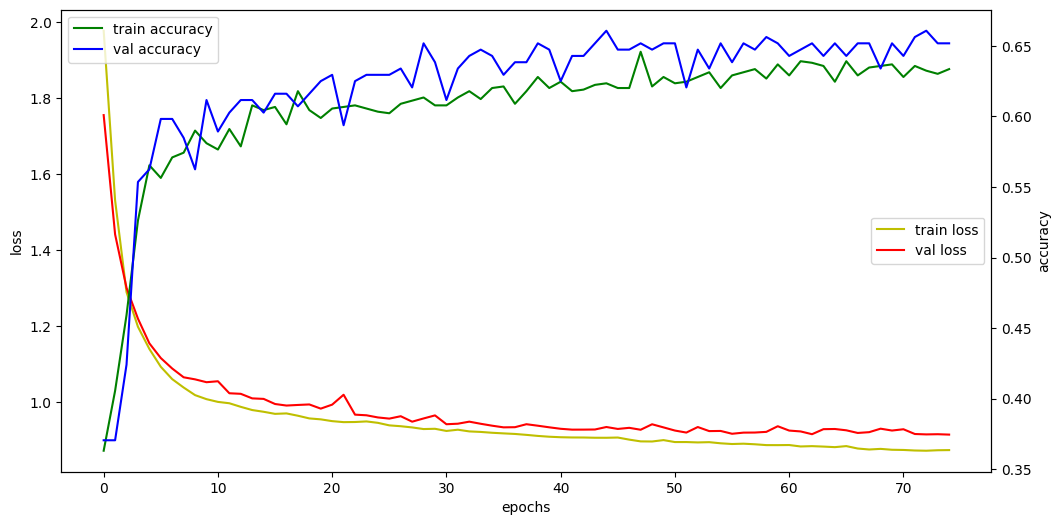

In [9]:
fig, loss_ax = plt.subplots(figsize=(12,6))
loss_ax.plot(hist.history['loss'], 'y', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')
acc_ax = loss_ax.twinx()
acc_ax.plot(hist.history['accuracy'], 'g', label='train accuracy')
acc_ax.plot(hist.history['val_accuracy'], 'b', label='val accuracy')
loss_ax.set_xlabel('epochs')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuracy')
loss_ax.legend(loc='center right')
acc_ax.legend()
plt.show()

In [30]:
# 모델 평가하기
loss_and_metrics = model.evaluate(X_test, y_test, batch_size=100, verbose=1)
print('loss :', loss_and_metrics[0])
print('accuracy :', loss_and_metrics[1])

5/5 [==============================] - 0s 2ms/step - loss: 0.9207 - accuracy: 0.6104
loss : 0.9206516146659851
accuracy : 0.6104166507720947


In [31]:
# 모델 저장
model.save('model/09_mnist.h5')

In [32]:
model2 = load_model('model09/mnist-045-val0.6607.h5')

In [33]:
loss_and_metrics2 = model2.evaluate(X_test, y_test, batch_size=32, verbose=0)
print('loss :', loss_and_acc2[0])
print('accuracy :', loss_and_acc2[1])

loss : 0.9336450099945068
accuracy : 0.6041666865348816


In [35]:
# 성능 지표(crosstab)
# Y_test : 0 0 1 0 0 0 (3등급, 4등급, 5등급, 6등급, 7등급, 8등급)
y_origin = np.argmax(y_test, axis=1) # Y_test의 실제값(pd.getdummies)
yhat = model.predict(X_test).argmax(axis=1) # 예측값
pd.crosstab(y_origin, yhat, rownames=['real'], colnames=['predict'])

15/15 [==============================] - 0s 1ms/step


predict,5,6,7
real,,,
3,2,1,0
4,13,3,0
5,166,37,1
6,76,106,10
7,5,34,21
8,0,2,3


In [50]:
# 6. 모델 사용하기
input_data = np.array([6.9, 0.605, 0.12, 10.7, 0.073, 40.0, 83.0, 0.9993, 3.45, 0.52, 9.4])
scaled_data = x_scaler.transform(input_data.reshape(1,11))
print(np.argmax(model.predict(scaled_data), axis=1), '등급으로 예측함')

1/1 [==============================] - 0s 19ms/step
[5] 등급으로 예측함
